# 알약 식별 프로젝트 - 그게뭐약

## 필요 라이브러리 설치

In [ ]:
# Download TorchVision repo to use some files from
# references/detection
!pip install pycocotools --quiet
!git clone https://github.com/pytorch/vision.git
!git checkout v0.3.0

!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./

Cloning into 'vision'...
remote: Enumerating objects: 196956, done.
remote: Counting objects: 100% (6812/6812), done.
remote: Compressing objects: 100% (603/603), done.
remote: Total 196956 (delta 6310), reused 6655 (delta 6197), pack-reused 190144
Receiving objects: 100% (196956/196956), 396.56 MiB | 24.90 MiB/s, done.
Resolving deltas: 100% (177245/177245), done.
fatal: not a git repository (or any of the parent directories): .git


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1" # cuda 관련 오류 자세하게 알려주는 코드 (코랩용)
# torch 모듈 전에 사용

In [ ]:
import torch

if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [ ]:
# Basic python and ML Libraries
import os
import random
import numpy as np
import pandas as pd
# for ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# We will be reading images using OpenCV
import cv2

# xml library for parsing xml files
from xml.etree import ElementTree as et

# matplotlib for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# torchvision libraries
import torch
import torchvision
from torchvision import transforms as torchtrans  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# these are the helper libraries imported.
from engine import train_one_epoch, evaluate
import utils
import transforms as T

# for image augmentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import random
import shutil

In [ ]:
# a = [1,2,3,4,5]
# a[1:3]

## train, test 데이터 분리 / image, annotation 분리

In [ ]:
!mkdir alyac_img
!mkdir alyac_xml

In [ ]:
!unzip -qq '/content/drive/MyDrive/alyac_img.zip' -d '/content/alyac_img'
!unzip -qq '/content/drive/MyDrive/All_xml.zip' -d '/content/alyac_xml'

In [ ]:
# print(len(os.listdir('/content/drive/MyDrive/그게뭐약/alayc_img/alayc_img')))  # image file
# print(len(os.listdir('/content/drive/MyDrive/그게뭐약/alayc_xml/alayc_xml')))  # xml file
# !mkdir alyac_img
# !mkdir alyac_xml

# !unzip -qq '/content/drive/MyDrive/alyac_img.zip' -d '/content/alyac_img'
# !unzip -qq '/content/drive/MyDrive/All_xml.zip' -d '/content/alyac_xml'

!mkdir test_images
!mkdir test_annotations
!mkdir images
!mkdir annotations
!mkdir files_dir
!mkdir test_dir

random.seed(1234)
idx = random.sample(range(24000), 4800)  # 8:2

for img in np.array(sorted(os.listdir('/content/alyac_img'))):
    shutil.copy('/content/alyac_img/'+img, 'images/'+img)

for annot in np.array(sorted(os.listdir('/content/alyac_xml'))):
    shutil.copy('/content/alyac_xml/'+annot, 'annotations/'+annot)

for img in np.array(sorted(os.listdir('/content/alyac_img')))[idx]:
    shutil.move('images/'+img, 'test_images/'+img)

for annot in np.array(sorted(os.listdir('/content/alyac_xml')))[idx]:
    shutil.move('annotations/'+annot, 'test_annotations/'+annot)

for files in sorted(os.listdir('/content/images')):
    shutil.move('/content/images/'+files, '/content/files_dir/'+files)

for files in sorted(os.listdir('/content/annotations')):
    shutil.move('/content/annotations/'+files, '/content/files_dir/'+files)

for files in sorted(os.listdir('/content/test_images')):
    shutil.move('/content/test_images/'+files, '/content/test_dir/'+files)

for files in sorted(os.listdir('/content/test_annotations')):
    shutil.move('/content/test_annotations/'+files, '/content/test_dir/'+files)

print(len(os.listdir('annotations')))
print(len(os.listdir('images')))
print(len(os.listdir('test_annotations')))
print(len(os.listdir('test_images')))
print(len(os.listdir('files_dir')))
print(len(os.listdir('test_dir')))

0
0
0
0
38400
9600


In [ ]:
# print(len(os.listdir('/content/drive/MyDrive/alyac_ALL')))  # image file

# !mkdir files_dir
# !mkdir test_dir

# for files in np.array(sorted(os.listdir('/content/drive/MyDrive/alyac_ALL'))):
#     shutil.copy('/content/drive/MyDrive/alyac_ALL/'+files, 'files_dir/'+files)

# # # print(sorted(os.listdir('/content/files_dir')))
# # # random.seed(1234)
# # # idx = []
# # # for i in os.listdir('/content/files_dir'):
# # #   idx.append(i)
# # #   idx.sort()
# # # idx = idx[569:]


# # # for files in np.array(sorted(os.listdir('/content/drive/MyDrive/alyac_ALL'))):
# # #     shutil.copy('/content/drive/MyDrive/alyac_ALL/'+files, 'files_dir/'+files)

# for files in sorted(os.listdir('/content/files_dir'))[569:]:
#     shutil.move('files_dir/'+files, 'test_dir/'+files)

# # print(sorted(os.listdir('/content/test_dir')))

# # # # shutil.copy(source, destination) 
# # # # >> source : 소스 파일의 경로를 나타내는 문자열
# # # # >> destination : 대상 파일 또는 디렉토리의 경로를 나타내는 문자열

# print(len(os.listdir('files_dir')))
# print(len(os.listdir('test_dir')))

In [ ]:
# os.listdir('test_dir')

In [ ]:
# os.listdir('files_dir')

In [ ]:
files_dir = '/content/files_dir'
test_dir = '/content/test_dir'

## class list 확인

In [ ]:
from os import listdir

def read_annotations(xml_file: str):
    tree = et.parse(xml_file)  # xml 파일 읽어오기
    root = tree.getroot()   # get root node   # xml 문서의 최상단 루트 태그

    classes_list = []

    file_name = root.find('filename').text    # root 하위에 'filename' 태그를 찾아서 text 읽기 (= find().text)
    for obj in root.iter('object'):    # root 태그에서 iter('object')만 순회.  # find는 해당 태그의 바로 자식만 탐색 / iter는 모든 자식에 대해 탐색
        object_label = obj.find("name").text     # 이미지 name (=class)

        classes = [object_label]
        # print(classes)
        classes_list.append(classes)
        # print(classes_list)
    return classes_list

def get_classes(dir):
    classes = []
    for file in listdir(dir):
        if 'xml' in file.lower():
            classes_file = file.replace(file.split('.')[-1], 'xml')
            class_name = read_annotations(dir+classes_file)
            classes.append(class_name)
            # print(classes)
    return classes

classes = get_classes('/content/alyac_xml/')

class_list = []
for t in classes:
    if t not in class_list:
        class_list.append(t[0][0])

class_list = pd.Series(class_list).unique()
class_list = class_list.tolist()
class_list

['22408',
 '22605',
 '22074',
 '17159',
 '3982',
 '3324',
 '8998',
 '17458',
 '12063',
 '2070']

In [ ]:
# import pandas as pd

# class_list = []
# for t in os.listdir('/content/drive/MyDrive/alyac_ALL'):
#   t = t.replace(t.split('.')[-1], '')
#   t = t.replace('.','')
#   # if t not in class_list:
#   class_list.append(t)
#   # pd.Series(class_list).unique()
# # print(class_list)

In [ ]:
# import pandas as pd

# class_list = []
# for t in os.listdir('/content/drive/MyDrive/alyac_ALL'):
#   class_list.append(t)

# len(class_list)

## 데이터셋 class

In [ ]:
class PillImagesDataset(torch.utils.data.Dataset):
  def __init__(self, files_dir, width, height, transforms=None):
    self.transforms = transforms
    self.files_dir = files_dir
    self.height = height
    self.width = width

    # sorting the images for consistency
    self.imgs = [image for image in sorted(os.listdir(files_dir))
                    if image[-4:]=='.jpg']
    
    # classes : 0 index is reserved for background
    self.classes = class_list

  def __getitem__(self, idx):

    img_name = self.imgs[idx]
    image_path = os.path.join(self.files_dir, img_name)

    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
    img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
    # diving by 255
    img_res /= 255.0

    # annotation file
    annot_filename = img_name[:-4] + '.xml'
    annot_file_path = os.path.join(self.files_dir, annot_filename)
    # print(annot_filename)

    boxes = []
    labels = []
    tree = et.parse(annot_file_path)
    root = tree.getroot()

    wt = img.shape[1]
    ht = img.shape[0]

    for member in root.findall('object'):
      labels.append(self.classes.index(member.find('name').text))

      # bounding box
      xmin = int(member.find('bndbox').find('xmin').text)
      xmax = int(member.find('bndbox').find('xmax').text)

      ymin = int(member.find('bndbox').find('ymin').text)
      ymax = int(member.find('bndbox').find('ymax').text)

      xmin_corr = (xmin/wt)*self.width
      xmax_corr = (xmax/wt)*self.width
      ymin_corr = (ymin/ht)*self.height
      ymax_corr = (ymax/ht)*self.height

      boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])

      # xmin = float(member.find('bndbox').find('xmin').text)
      # ymin = float(member.find('bndbox').find('ymin').text)
      # xmax = float(member.find('bndbox').find('xmax').text)
      # ymax = float(member.find('bndbox').find('ymax').text)
      # boxes.append([xmin, xmax, ymin, ymax])
    boxes = torch.as_tensor(boxes, dtype=torch.float32)

    area = (boxes[:, 3] - boxes[:, 1])*(boxes[:, 2]-boxes[:, 0])

    # suppose all instances are not crowd
    iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)

    labels = torch.as_tensor(labels, dtype=torch.int64)

    target = {}
    target['boxes'] = boxes
    target['labels'] = labels
    target['area'] = area
    target['iscrowed'] = iscrowd

    image_id = torch.tensor([idx])
    target['image_id'] = image_id

    if self.transforms:

      sample = self.transforms(image = img_res,
                               bboxes = target['boxes'],
                               labels = labels)
      img_res = sample['image']
      target['boxes'] = torch.Tensor(sample['bboxes'])

    return img_res, target

  def __len__(self):
    return len(self.imgs)

# check dataset
dataset = PillImagesDataset(files_dir, 150, 150)
print('length of dataset = ', len(dataset), '\n')

# getting the image and target for a test index. Feel free to change the index
img, target = dataset[20]
print(img.shape, '\n', target)

length of dataset =  19200 

(150, 150, 3) 
 {'boxes': tensor([[ 48.,   5.,  99., 143.]]), 'labels': tensor([8]), 'area': tensor([7038.]), 'iscrowed': tensor([0]), 'image_id': tensor([20])}


## bounding box 이미지

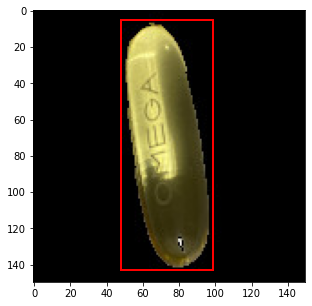

In [ ]:
# Function to visualize bounding boxes in the image

def plot_img_bbox(img, target, label):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    
    for box in (target['boxes']):
        box = box.detach().cpu().numpy()
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
        if label is not None:
            label = target['labels']
            a.text(box[0]+0.5 * (box[2]-box[0]), box[1] + 0.5 * (box[3]-box[1]), label, ha='center', va='center', color='r')
    plt.show()
    
# plotting the image with bboxes. Feel free to change the index
img, target = dataset[25]
plot_img_bbox(img, target, _)

### object detect

In [ ]:
def get_object_detection_model(num_classes):

    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

    return model

In [ ]:
# Send train=True fro training transforms and False for val/test transforms
def get_transform(train):
    
    if train:
        return A.Compose([
                            A.HorizontalFlip(0.5),
                     # ToTensorV2 converts image to pytorch tensor without div by 255
                            ToTensorV2(p=1.0) 
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

## Dataset, DataLoader

In [ ]:
# use our dataset and defined transformations
dataset = PillImagesDataset('/content/files_dir', 480, 480, transforms= get_transform(train=True))
dataset_test = PillImagesDataset('/content/files_dir', 480, 480, transforms= get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

# train test split
test_split = 0.2
tsize = int(len(dataset)*test_split)
dataset = torch.utils.data.Subset(dataset, indices[:-tsize])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=16, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=4, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

In [ ]:
# to train on gpu if selected.
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


num_classes = len(class_list)

# get the model using our helper function
model = get_object_detection_model(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [ ]:
# training for 10 epochs
num_epochs = 20

for epoch in range(num_epochs):
    # training for one epoch
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [  0/960]  eta: 2:31:35  lr: 0.000010  loss: 3.0156 (3.0156)  loss_classifier: 2.8649 (2.8649)  loss_box_reg: 0.1457 (0.1457)  loss_objectness: 0.0016 (0.0016)  loss_rpn_box_reg: 0.0034 (0.0034)  time: 9.4741  data: 1.0109  max mem: 11316
Epoch: [0]  [ 10/960]  eta: 0:36:58  lr: 0.000062  loss: 2.8327 (2.7485)  loss_classifier: 2.7018 (2.5957)  loss_box_reg: 0.1457 (0.1448)  loss_objectness: 0.0043 (0.0044)  loss_rpn_box_reg: 0.0034 (0.0036)  time: 2.3355  data: 0.1358  max mem: 11576
Epoch: [0]  [ 20/960]  eta: 0:31:13  lr: 0.000114  loss: 2.0233 (2.0157)  loss_classifier: 1.8683 (1.8641)  loss_box_reg: 0.1383 (0.1445)  loss_objectness: 0.0037 (0.0037)  loss_rpn_box_reg: 0.0032 (0.0033)  time: 1.6191  data: 0.0518  max mem: 11576
Epoch: [0]  [ 30/960]  eta: 0:28:46  lr: 0.000166  loss: 0.5173 (1.4836)  loss_classifier: 0.3435 (1.3325)  loss_box_reg: 0.1438 (0.1434)  loss_objectness: 0.0030 (0.0042)  loss_rpn_box_reg: 0.0032 (0.0035)  time: 1.5936  data: 0.0573  max mem: 11

In [ ]:
def mAP(result):
    ap = 0
    for r in result:
        ap += r['AP']
    mAP = ap / len(result)
    
    return mAP

In [ ]:
# the function takes the original prediction and the iou threshold.

def apply_nms(orig_prediction, iou_thresh=0.3):
    
    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')

In [ ]:
def make_prediction(model, img, threshold):
    model.eval()
    preds = model(img)
    for id in range(len(preds)) :
        idx_list = []

        for idx, score in enumerate(preds[id]['scores']) :
            if score > threshold : 
                idx_list.append(idx)

        preds[id]['boxes'] = preds[id]['boxes'][idx_list].cpu()
        preds[id]['labels'] = preds[id]['labels'][idx_list].cpu()
        preds[id]['scores'] = preds[id]['scores'][idx_list].cpu()

    return preds

### 이미지 확인

In [ ]:
img_path = ''
f = open(img_path, 'rb')
img = Image.open(f).convert('RGB')

img_T = data_transform(img)
imgs = list(img.to(device for img in img_T))

## 테스트셋

In [ ]:
pred = make_prediction(model, img.unsqueeze_(0), 0.5)

In [ ]:
with torch.no_grad(): 
    # 테스트셋 배치사이즈= 2
    for imgs, annotations in data_loader_test:
        imgs = list(img.to(device) for img in imgs)

    for img in imgs:
        pred.append(make_prediction(model, imgs, 0.1))
        print(pred)

[[{'boxes': tensor([[ 45.6734, 256.8290, 330.7707, 387.6472]]), 'labels': tensor([2]), 'scores': tensor([0.9989])}, {'boxes': tensor([[ 24.0923, 149.7887, 363.0623, 304.5306]]), 'labels': tensor([2]), 'scores': tensor([0.9996])}, {'boxes': tensor([[ 38.4300,  85.8263, 407.1057, 260.4123]]), 'labels': tensor([7]), 'scores': tensor([0.9991])}, {'boxes': tensor([[ 52.0537,  74.9332, 448.1441, 412.4889]]), 'labels': tensor([4]), 'scores': tensor([0.9988])}]]
[[{'boxes': tensor([[ 45.6734, 256.8290, 330.7707, 387.6472]]), 'labels': tensor([2]), 'scores': tensor([0.9989])}, {'boxes': tensor([[ 24.0923, 149.7887, 363.0623, 304.5306]]), 'labels': tensor([2]), 'scores': tensor([0.9996])}, {'boxes': tensor([[ 38.4300,  85.8263, 407.1057, 260.4123]]), 'labels': tensor([7]), 'scores': tensor([0.9991])}, {'boxes': tensor([[ 52.0537,  74.9332, 448.1441, 412.4889]]), 'labels': tensor([4]), 'scores': tensor([0.9988])}], [{'boxes': tensor([[ 45.6734, 256.8290, 330.7707, 387.6472]]), 'labels': tensor([2

In [ ]:
import utils_ObjectDetection as utils

In [ ]:
# from tqdm import tqdm

# labels = []
# preds_adj_all = []
# annot_all = []

# for im, target in tqdm(data_loader_test, leave=True):
#     im = list(img.to(device) for img in im)
    
#     for t in target:
#         labels += t['labels']
        
#     with torch.no_grad():
#         preds_adj = make_prediction(model, img, 0.5)
#         preds_adj = [{k: v.to(torch.device('cpu')) for k,v in t.item()} for t in preds_adj]
#         preds_adj_all.append(preds_adj)
#         annot_all.append(annot)

100%|██████████| 960/960 [03:43<00:00,  4.29it/s]


In [ ]:
from tqdm import tqdm

labels = []
preds_adj_all = []
annot_all = []

for im, annot in tqdm(data_loader_test, position = 0, leave = True):
    im = list(img.to(device) for img in im)
    #annot = [{k: v.to(device) for k, v in t.items()} for t in annot]

    for t in annot:
        labels += t['labels']

    with torch.no_grad():
        preds_adj = make_prediction(model, im, 0.5)
        preds_adj = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in preds_adj]
        preds_adj_all.append(preds_adj)
        annot_all.append(annot)

100%|██████████| 960/960 [03:44<00:00,  4.28it/s]


## mAP 계산

In [ ]:
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += utils.get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=0.5)
    
true_positives, pred_scores, pred_labels = [torch.cat(x.0) for x in list(zip(*sample_metrics))]  # 배치가 전부 합쳐짐
precision, recall, AP, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels. torch.tensor(labels))
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')
print(f'precision : {precision}')
print(f'recall : {recall}')
print(f'f1 : {f1}')
print(f'ap_class : {ap_class}')

mAP : 0.8994528658582717
AP : tensor([0.0000, 0.9998, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.9948], dtype=torch.float64)
precision : tensor([0.0000, 0.9768, 1.0000, 1.0000, 0.9919, 0.9823, 0.9927, 1.0000, 0.9760,
        0.9719], dtype=torch.float64)
recall : tensor([0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.9948], dtype=torch.float64)
f1 : tensor([0.0000, 0.9883, 1.0000, 1.0000, 0.9959, 0.9911, 0.9963, 1.0000, 0.9879,
        0.9832], dtype=torch.float64)
ap_class : tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


In [ ]:
# pick one image from the test set
img, target = dataset_test[5]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('predicted #boxes: ', len(prediction['labels']))
print('real #boxes: ', len(target['labels']))

predicted #boxes:  1
real #boxes:  1


In [ ]:
test_dataset = PillImagesDataset(test_dir, 480, 480, transforms= get_transform(train=True))
# pick one image from the test set
img, target = test_dataset[260]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('EXPECTED OUTPUT\n')
plot_img_bbox(torch_to_pil(img), target, target['labels'])
print('MODEL OUTPUT\n')
nms_prediction = apply_nms(prediction, iou_thresh=0.01)

plot_img_bbox(torch_to_pil(img), nms_prediction, target['labels'])

EXPECTED OUTPUT



TypeError: ignored

EXPECTED OUTPUT


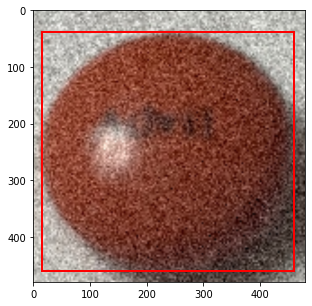

In [ ]:
print('EXPECTED OUTPUT')
plot_img_bbox(torch_to_pil(img), target, _)

In [ ]:
print('MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img), prediction, _)

In [ ]:
nms_prediction = apply_nms(prediction, iou_thresh=0.2)
print('NMS APPLIED MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img), nms_prediction, target['labels'])

In [ ]:
test_dataset = PillImagesDataset(test_dir, 480, 480, transforms= get_transform(train=True))
# pick one image from the test set
img, target = test_dataset[369]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('EXPECTED OUTPUT\n')
plot_img_bbox(torch_to_pil(img), target, target['labels'])
print('MODEL OUTPUT\n')
nms_prediction = apply_nms(prediction, iou_thresh=0.01)

plot_img_bbox(torch_to_pil(img), nms_prediction, target['labels'])

In [ ]:
test_dataset = PillImagesDataset(test_dir, 480, 480, transforms= get_transform(train=True))
# pick one image from the test set
img, target = test_dataset[10]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('EXPECTED OUTPUT\n')
plot_img_bbox(torch_to_pil(img), target, target['labels'])
print('MODEL OUTPUT\n')
nms_prediction = apply_nms(prediction, iou_thresh=0.01)

plot_img_bbox(torch_to_pil(img), nms_prediction, target['labels'])

In [ ]:
test_dataset = PillImagesDataset(test_dir, 480, 480, transforms= get_transform(train=True))
# pick one image from the test set
img, target = test_dataset[1355]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('EXPECTED OUTPUT\n')
plot_img_bbox(torch_to_pil(img), target, target['labels'])
print('MODEL OUTPUT\n')
nms_prediction = apply_nms(prediction, iou_thresh=0.01)

plot_img_bbox(torch_to_pil(img), nms_prediction, target['labels'])

In [ ]:
test_dataset = PillImagesDataset(test_dir, 480, 480, transforms= get_transform(train=True))
# pick one image from the test set
img, target = test_dataset[100]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('EXPECTED OUTPUT\n')
plot_img_bbox(torch_to_pil(img), target, target['labels'])
print('MODEL OUTPUT\n')
nms_prediction = apply_nms(prediction, iou_thresh=0.01)

plot_img_bbox(torch_to_pil(img), nms_prediction, target['labels'])

In [ ]:
test_dataset = PillImagesDataset(test_dir, 480, 480, transforms= get_transform(train=True))
# pick one image from the test set
img, target = test_dataset[220]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('EXPECTED OUTPUT\n')
plot_img_bbox(torch_to_pil(img), target, target['labels'])
print('MODEL OUTPUT\n')
nms_prediction = apply_nms(prediction, iou_thresh=0.01)

plot_img_bbox(torch_to_pil(img), nms_prediction, target['labels'])

In [ ]:
test_dataset = PillImagesDataset(test_dir, 480, 480, transforms= get_transform(train=True))
# pick one image from the test set
img, target = test_dataset[130]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('EXPECTED OUTPUT\n')
plot_img_bbox(torch_to_pil(img), target, target['labels'])
print('MODEL OUTPUT\n')
nms_prediction = apply_nms(prediction, iou_thresh=0.01)

plot_img_bbox(torch_to_pil(img), nms_prediction, target['labels'])

In [ ]:
test_dataset = PillImagesDataset(test_dir, 480, 480, transforms= get_transform(train=True))
# pick one image from the test set
img, target = test_dataset[321]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('EXPECTED OUTPUT\n')
plot_img_bbox(torch_to_pil(img), target, target['labels'])
print('MODEL OUTPUT\n')
nms_prediction = apply_nms(prediction, iou_thresh=0.01)

plot_img_bbox(torch_to_pil(img), nms_prediction, target['labels'])

In [ ]:
test_dataset = PillImagesDataset(test_dir, 480, 480, transforms= get_transform(train=True))
# pick one image from the test set
img, target = test_dataset[450]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('EXPECTED OUTPUT\n')
plot_img_bbox(torch_to_pil(img), target, target['labels'])
print('MODEL OUTPUT\n')
nms_prediction = apply_nms(prediction, iou_thresh=0.01)

plot_img_bbox(torch_to_pil(img), nms_prediction, target['labels'])

In [ ]:
test_dataset = PillImagesDataset(test_dir, 480, 480, transforms= get_transform(train=True))
# pick one image from the test set
img, target = test_dataset[300]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('EXPECTED OUTPUT\n')
plot_img_bbox(torch_to_pil(img), target, target['labels'])
print('MODEL OUTPUT\n')
nms_prediction = apply_nms(prediction, iou_thresh=0.01)

plot_img_bbox(torch_to_pil(img), nms_prediction, target['labels'])

In [ ]:
test_dataset = PillImagesDataset(test_dir, 480, 480, transforms= get_transform(train=True))
# pick one image from the test set
img, target = test_dataset[650]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('EXPECTED OUTPUT\n')
plot_img_bbox(torch_to_pil(img), target, target['labels'])
print('MODEL OUTPUT\n')
nms_prediction = apply_nms(prediction, iou_thresh=0.01)

plot_img_bbox(torch_to_pil(img), nms_prediction, target['labels'])

In [ ]:
test_dataset = PillImagesDataset(test_dir, 480, 480, transforms= get_transform(train=True))
# pick one image from the test set
img, target = test_dataset[1250]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('EXPECTED OUTPUT\n')
plot_img_bbox(torch_to_pil(img), target, target['labels'])
print('MODEL OUTPUT\n')
nms_prediction = apply_nms(prediction, iou_thresh=0.01)

plot_img_bbox(torch_to_pil(img), nms_prediction, target['labels'])

In [ ]:
import PIL
import torchvision.transforms as transforms
def imagecrop(img, pred, idx):
  xmin, ymin, xmax, ymax = pred['boxes'].numpy()[0]

  img_t = img

  tf = transforms.ToPILImage()
  img_t = tf(img_t)

  image_crop = img_t.crop([xmin, ymin, xmax, ymax])
  image_crop.save('/content/cropimage/'+str(idx) +'.png')

  plt.imshow(image_crop)
  plt.show()

  return image_crop

In [ ]:
select_cnt = 30
cnt = 0
with torch.no_grad(): 
    # 테스트셋 배치사이즈= 2
    for imgs, annotations in data_loader_test:
        imgs = list(img.to(device) for img in imgs)

        pred = make_prediction(model, imgs, 0.1)
        print(pred)
        
        if cnt == select_cnt:
          break

        cnt += 1

[{'boxes': tensor([], size=(0, 4)), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([])}, {'boxes': tensor([[ 94.0253, 183.9984, 341.0659, 368.2633]]), 'labels': tensor([3]), 'scores': tensor([0.9991])}, {'boxes': tensor([[135.4041, 161.0030, 346.0729, 317.2571]]), 'labels': tensor([4]), 'scores': tensor([0.9991])}, {'boxes': tensor([[156.8857, 183.1798, 317.3669, 292.9556]]), 'labels': tensor([8]), 'scores': tensor([0.9979])}]
[{'boxes': tensor([[120.6974, 151.5807, 352.8303, 289.2769]]), 'labels': tensor([9]), 'scores': tensor([0.9996])}, {'boxes': tensor([[164.3767, 188.4074, 343.5648, 285.9337]]), 'labels': tensor([8]), 'scores': tensor([0.9885])}, {'boxes': tensor([[ 77.8682, 115.7596, 372.3424, 298.9004]]), 'labels': tensor([9]), 'scores': tensor([0.9993])}, {'boxes': tensor([[ 76.8163, 105.4187, 414.1614, 393.1089]]), 'labels': tensor([6]), 'scores': tensor([0.9990])}]
[{'boxes': tensor([[ 83.3645, 174.1452, 407.3599, 349.3970],
        [ 71.9089, 168.9650, 403.2018, 3

In [ ]:
iterA = iter(data_loader_test)

EXPECTED OUTPUT



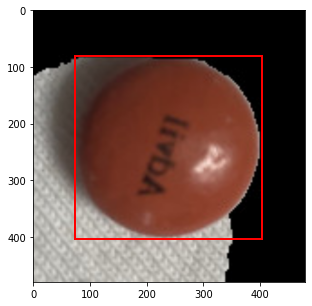

MODEL OUTPUT

<class 'tuple'>


FileNotFoundError: ignored

In [ ]:
test_dataset = PillImagesDataset(test_dir, 480, 480, transforms= get_transform(train=True))
# pick one image from the test set
img, target = test_dataset[650]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('EXPECTED OUTPUT\n')
plot_img_bbox(torch_to_pil(img), target)
print('MODEL OUTPUT\n')
nms_prediction = apply_nms(prediction, iou_thresh=0.01)
# img_test.unsqueeze(0).cuda()).deatch().cpu().clone().numpy()
# img = img.unsqueeze(0).cpu().clone().numpy()
# plot_img_bbox(torch_to_pil(img.cpu()), nms_prediction)
with torch.no_grad(): 
  _idx = 650
  imgs, annotations = next(iterA)
  print(type(imgs))
  imgs = list(img.to(device) for img in imgs)
  pred = make_prediction(model, imgs, 0.5)

  _idx = 0
  img = imagecrop(imgs[_idx], pred[_idx], _idx)

In [ ]:
_idx = 0
print("Target : ", annotations[_idx]['labels'])
plot_img_bbox(torch_to_pil(img), target, target['labels'])
print("Prediction : ", pred[_idx]['labels'])
nms_prediction = apply_nms(prediction, iou_thresh=0.01)
img = imagecrop(imgs[_idx], pred[_idx], _idx)

Target :  tensor([5])


TypeError: ignored

<class 'tuple'>


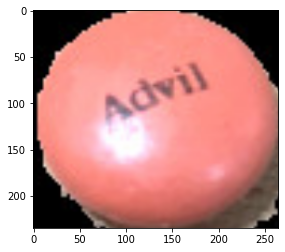

In [ ]:
with torch.no_grad(): 
  imgs, annotations = next(iterA)
  print(type(imgs))
  imgs = list(img.to(device) for img in imgs)
  pred = make_prediction(model, imgs, 0.5)

  _idx = 1
  # print("Target : ", annotations[_idx]['labels'])
  # plot_image_from_output(imgs[_idx], annotations[_idx], annotations[_idx]['labels'])

  # print("Prediction : ", pred[_idx]['labels'])
  # plot_img_bbox(torch_to_pil(img), nms_prediction)

  img = imagecrop(imgs[_idx], pred[_idx], _idx)

## Easyocr

In [ ]:
!pip install easyocr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 70.8 MB 17 kB/s 
     |████████████████████████████████| 47.6 MB 1.2 MB/s 
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.6.0.66
    Uninstalling opencv-python-headless-4.6.0.66:
      Successfully uninstalled opencv-python-headless-4.6.0.66


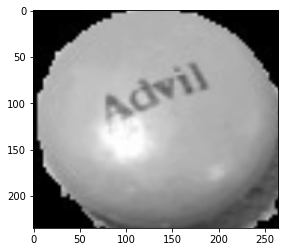

[([[58.540235122517004, 86.9862116102653], [186.58369197795307, 39.12833784386489], [202.459764877483, 86.0137883897347], [74.41630802204693, 133.8716621561351]], 'Advil', 0.9687793598135833)]


In [ ]:
import easyocr
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
from PIL import ImageFont, ImageDraw, Image

reader = easyocr.Reader(['ko','en']) # need to run only once to load model into memory
result = reader.readtext('/content/cropimage/1.png')

img_ori    = cv2.imread('/content/cropimage/1.png')
img = Image.fromarray(img_ori)
font = ImageFont.truetype("/content/ARIALUNI.TTF",20)
draw = ImageDraw.Draw(img)

np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(255, 3),dtype="uint8")


for i in result :
    x = i[0][0][0]
    y = i[0][0][1]
    w = i[0][1][0] - i[0][0][0]
    h = i[0][2][1] - i[0][1][1]
    
    color_idx = random.randint(0,255)
    color = [int(c) for c in COLORS[color_idx]]
    
#    cv2.putText(img, str(i[1]), (int((x + x + w) / 2) , y-2), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
#    img = cv2.rectangle(img, (x, y), (x+w, y+h), color, 2)
    draw.rectangle(((x, y), (x+w, y+h)), outline=tuple(color), width=2)
    draw.text((int((x + x + w) / 2) , y-2),str(i[1]), font=font, fill=tuple(color),)

img_gray = cv2.cvtColor(img_ori, cv2.COLOR_BGR2GRAY)

plt.imshow(img_gray, cmap='gray')
plt.show()
# cv2.imshow("test",img)
# cv2.waitKey(0)

print(result)